## Hierarchical Feature Engineering

This notebook explores of feature engineering and modelling for hierarchical time series. The provided dataset has four groups (hyperioncode) with a supplier and part number. Each group has between 10,000 to 40,000 observations. In the forecast, we have many parts and suppliers that have low counts and sporadic demand.

In [22]:
import numpy as np
import pandas as pd

from datasetsforecast.hierarchical import HierarchicalData, HierarchicalInfo
group_name = 'Traffic'
group = HierarchicalInfo.get_group(group_name)
y_hier, s_df, tags = HierarchicalData.load('./data', group_name)
s_df = s_df.reset_index(names="unique_id")
y_hier['ds'] = pd.to_datetime(y_hier['ds'])

This data is hierarchical, but with sparse observations. We need to normalize the data and make a proper hierarchical dataframe, ensuring that each group / subgroup is accounted for.

In [27]:
y_hier

,unique_id,ds,y
0,Total,2008-01-01,1536.0182
1,Total,2008-01-02,1619.2435
2,Total,2008-01-03,1423.6574
3,Total,2008-01-04,1096.3325
4,Total,2008-01-05,974.5526
...,...,...,...
75757,Bottom200,2008-12-27,13.0458
75758,Bottom200,2008-12-28,11.6035
75759,Bottom200,2008-12-29,13.4012
75760,Bottom200,2008-12-30,13.3731


Next thing we need to do is resample and fill missing values with zero - pretty much every method we use will require regular time series data.

In [26]:
from utilsforecast.preprocessing import fill_gaps
y_filled = (
    fill_gaps(y_hier, freq='D', start='global', end='global')
    .fillna(0)
    .sort_values(by=['unique_id', 'ds'])
)
y_filled

,unique_id,ds,y
0,Bottom1,2008-01-01,8.1370
1,Bottom1,2008-01-02,8.9488
2,Bottom1,2008-01-03,8.1359
3,Bottom1,2008-01-04,6.4700
4,Bottom1,2008-01-05,5.5741
...,...,...,...
75757,y22,2008-12-27,396.3433
75758,y22,2008-12-28,392.0859
75759,y22,2008-12-29,414.2046
75760,y22,2008-12-30,437.0146


In [37]:
from utilsforecast.plotting import plot_series
plot_series(y_filled, engine='plotly', ids=['Total', 'y11', 'Bottom9', 'Bottom85'])

Let's setup a problem to predict the next 3 months of demand. Let's assume intermittent series and use a naive, ARIMA, and ADIDA (intermittent model). This training can also be distributed using Spark!

https://nixtlaverse.nixtla.io/statsforecast/docs/distributed/spark.html

https://nixtlaverse.nixtla.io/statsforecast/docs/experiments/prophet_spark_m5.html

In [38]:
# Let's train some baseline moodels
from statsforecast.models import Naive, ADIDA, AutoARIMA
from statsforecast.core import StatsForecast

# Split train/test sets
y_test_df  = y_filled.groupby('unique_id', as_index=False).tail(14)
y_train_df = y_filled.drop(y_test_df.index)

# Compute base Naive and ADIDA (intermittent model) predictions
fcst = StatsForecast(models=[
    Naive(),
    AutoARIMA(),
    ADIDA()
    ], freq='D', n_jobs=-1)

In [39]:
y_hat_df = fcst.forecast(df=y_train_df, h=14, fitted=True)

# This is necessary for the reconciliation step
y_fitted_df = fcst.forecast_fitted_values()

/Users/scott.mckean/Repos/time_series/ts_env/lib/python3.10/site-packages/statsforecast/models.py:3825: UserWarning: Computing fitted values for ADIDA is very expensive
  warnings.warn("Computing fitted values for ADIDA is very expensive")
/Users/scott.mckean/Repos/time_series/ts_env/lib/python3.10/site-packages/statsforecast/models.py:3825: UserWarning: Computing fitted values for ADIDA is very expensive
  warnings.warn("Computing fitted values for ADIDA is very expensive")
/Users/scott.mckean/Repos/time_series/ts_env/lib/python3.10/site-packages/statsforecast/models.py:3825: UserWarning: Computing fitted values for ADIDA is very expensive
  warnings.warn("Computing fitted values for ADIDA is very expensive")
/Users/scott.mckean/Repos/time_series/ts_env/lib/python3.10/site-packages/statsforecast/models.py:3825: UserWarning: Computing fitted values for ADIDA is very expensive
  warnings.warn("Computing fitted values for ADIDA is very expensive")
/Users/scott.mckean/Repos/time_series/ts

In [40]:
y_hat_df

,unique_id,ds,Naive,AutoARIMA,ADIDA
0,Bottom1,2008-12-18,6.5874,6.807466,7.342730
1,Bottom1,2008-12-19,6.5874,7.663699,7.342730
2,Bottom1,2008-12-20,6.5874,7.435419,7.342730
3,Bottom1,2008-12-21,6.5874,7.016749,7.342730
4,Bottom1,2008-12-22,6.5874,7.564004,7.342730
...,...,...,...,...,...
2893,y22,2008-12-27,296.9062,407.518338,365.784922
2894,y22,2008-12-28,296.9062,401.919841,365.784922
2895,y22,2008-12-29,296.9062,394.466321,365.784922
2896,y22,2008-12-30,296.9062,364.322534,365.784922


In [41]:
plot_series(y_filled, y_hat_df, engine='plotly', ids=['Total', 'y11', 'Bottom9', 'Bottom85'])

In [42]:
# Now let's evaluate our forecasts
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, rmse, mape

eval_df = evaluate(
    y_test_df.merge(y_hat_df, on=['unique_id', 'ds'], how='inner'),
    train_df=y_train_df,
    metrics=[mae, rmse, mape],
    models=['Naive', 'AutoARIMA', 'ADIDA']
)
eval_df

,unique_id,metric,Naive,AutoARIMA,ADIDA
0,Bottom1,mae,1.154250,0.737162,0.860684
1,Bottom10,mae,1.089679,0.654917,0.854278
2,Bottom100,mae,2.034593,1.226002,1.414404
3,Bottom101,mae,2.023014,0.959599,0.964712
4,Bottom102,mae,0.986529,0.636263,0.769064
...,...,...,...,...,...
616,y11,mape,0.185434,0.076518,0.123578
617,y12,mape,0.229635,0.114164,0.142805
618,y2,mape,0.201767,0.085196,0.135460
619,y21,mape,0.200983,0.105564,0.133752


In [43]:
summary = eval_df.drop(columns='unique_id').groupby('metric').mean().reset_index()
summary

,metric,Naive,AutoARIMA,ADIDA
0,mae,6.440956,2.895732,3.970030
1,mape,0.234591,0.181030,0.202671
2,rmse,7.419662,3.904444,5.045698


One of the features of hiearchical time series forecasting is reconciliation of forecasts. This is done to ensure that the sum of the forecasts for each group is equal to the forecast for the overall group. This may or may not be important depending on your use case.

In [44]:
from hierarchicalforecast.methods import BottomUpSparse, BottomUp, MinTrace
from hierarchicalforecast.core import HierarchicalReconciliation

reconcilers = [BottomUp(), MinTrace(method='mint_shrink')]

hrec = HierarchicalReconciliation(reconcilers=reconcilers)

Y_rec_df = hrec.reconcile(Y_hat_df=y_hat_df.fillna(0), 
                          Y_df=y_fitted_df.fillna(0),
                          S=s_df, tags=tags)
Y_rec_df.groupby('unique_id').head(2)

,unique_id,ds,Naive,AutoARIMA,ADIDA,Naive/BottomUp,AutoARIMA/BottomUp,ADIDA/BottomUp,Naive/MinTrace_method-mint_shrink,AutoARIMA/MinTrace_method-mint_shrink,ADIDA/MinTrace_method-mint_shrink
0,Total,2008-12-18,1217.1356,1286.818765,1504.550578,1217.1356,1306.067899,1484.877322,1217.1356,1269.603278,1526.919454
1,Total,2008-12-19,1217.1356,1616.728932,1504.550578,1217.1356,1484.653724,1484.877322,1217.1356,1564.383651,1526.919454
14,y1,2008-12-18,613.5664,639.394209,753.803735,613.5664,657.737046,746.021739,613.5664,641.572569,766.375791
15,y1,2008-12-19,613.5664,792.678913,753.803735,613.5664,746.484606,746.021739,613.5664,785.910240,766.375791
28,y2,2008-12-18,603.5692,651.133937,750.746843,603.5692,648.330854,738.855583,603.5692,628.030709,760.543663
...,...,...,...,...,...,...,...,...,...,...,...
2857,Bottom198,2008-12-19,1.5363,2.273351,2.229957,1.5363,2.273351,2.229957,1.5363,2.813721,2.504919
2870,Bottom199,2008-12-18,11.1997,11.267693,11.851627,11.1997,11.267693,11.851627,11.1997,11.218288,12.025962
2871,Bottom199,2008-12-19,11.1997,11.757045,11.851627,11.1997,11.757045,11.851627,11.1997,12.513321,12.025962
2884,Bottom200,2008-12-18,9.1496,9.211143,11.388118,9.1496,9.211143,11.388118,9.1496,8.941519,11.608644


Now let's get into feature engineering. I'm using Nixtla here because they have native Spark and Ray support and play very well at scale with Databricks. As we do feature engineering, we move from univariate classical time series models to local machine learning models and leverage the MLForecast library.

We have to be careful about our transforms and lags because we will drop a lot of the series that don't have sufficient data. So we will limit our lags to less than 6 months. This can be challenging because we can't capture yearly seasonality.

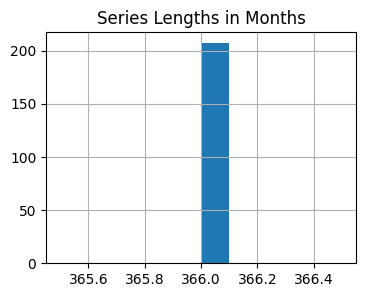

In [46]:
from matplotlib import pyplot as plt
y_filled.groupby('unique_id').count().y.hist(figsize=(4,3))
plt.title('Series Lengths in Months')
#plt.axvline(x=6, color='red', linestyle='-')
plt.show()

This gives us univariate features that lend themselves well to local machine learning models.

In [47]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

fcst = MLForecast(
    models=[],
    freq='MS',
    lags=[3, 6],
    lag_transforms={
        3: [ExpandingMean()],
        6: [RollingMean(window_size=3)]
    },
    date_features=['quarter', 'daysinmonth'],
    target_transforms=[Differences([1])],
)

feats = fcst.preprocess(df=y_filled)
display(feats.sample(5))

,unique_id,ds,y,lag3,lag6,expanding_mean_lag3,rolling_mean_lag6_window_size3,quarter,daysinmonth
46790,Bottom33,2008-11-04,0.2623,-2.3839,0.2555,-0.009222,0.125000,4,30
61013,Bottom69,2008-09-14,-0.6431,0.0369,1.5233,0.004882,-0.211767,3,30
9292,Bottom121,2008-05-22,2.1671,-1.0284,0.2920,-0.018324,0.620033,2,31
7910,Bottom118,2008-08-12,1.9288,0.1581,-0.1211,-0.112836,0.443100,3,31
36725,Bottom19,2008-05-05,0.1754,0.2827,-1.6128,-0.016329,-0.417367,2,31


We can also seasonal decompostion. To do this, we will need to drop series with less than 12 months of data since we need enough data to properly estimate seasonality. These can then be used as exogenous features in ML models.

https://nixtlaverse.nixtla.io/statsforecast/docs/how-to-guides/generating_features.html


In [48]:
series_lengths = y_train_df.groupby('unique_id').size()
valid_series = series_lengths[series_lengths >= 12].index
y_train_df_long = y_train_df[y_train_df['unique_id'].isin(valid_series)]
y_train_df_long

,unique_id,ds,y
0,Bottom1,2008-01-01,8.1370
1,Bottom1,2008-01-02,8.9488
2,Bottom1,2008-01-03,8.1359
3,Bottom1,2008-01-04,6.4700
4,Bottom1,2008-01-05,5.5741
...,...,...,...
75743,y22,2008-12-13,376.0506
75744,y22,2008-12-14,380.3588
75745,y22,2008-12-15,393.7427
75746,y22,2008-12-16,396.9217


In [49]:
from statsforecast.feature_engineering import mstl_decomposition
from statsforecast.models import AutoARIMA, MSTL

transformed_df, X_df = mstl_decomposition(
    y_train_df_long, 
    model=MSTL(season_length=3), 
    freq='MS', 
    h=3
    )
display(X_df.sample(5))

,unique_id,ds,trend,seasonal
203,Bottom16,2009-03-01,3.275546,-0.358561
438,Bottom50,2009-01-01,5.543316,0.041911
519,Bottom75,2009-01-01,6.478783,0.050571
429,Bottom48,2009-01-01,5.844674,-0.047914
91,Bottom126,2009-02-01,7.851111,-0.084136


Without additional exogenous features, we can only leverage lags, rolling means, decomposition information, and categorical features based on the unique_id (we will only use the hyperioncode for now). But we can use these features to train a local machine learning model, or a global model.

In [53]:
import lightgbm as lgb
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

models={
        'lightgbm': lgb.LGBMRegressor(verbosity=-1),
        'knn': KNeighborsRegressor(),
        'mlp': MLPRegressor(),
        'linear': LinearRegression()
    }

fcst = MLForecast(
    models=models,
    freq='D',
    lags=[3, 6],
    lag_transforms={
        3: [ExpandingMean(), RollingMean(window_size=3)],
        6: [ExpandingMean(), RollingMean(window_size=6)]
    },
    date_features=['quarter', 'daysinmonth'],
    target_transforms=[Differences([1])]
)

Let's run cross validation, because it is the right thing to do.

In [54]:
fcst.fit(
    df=y_train_df,
    static_features=[]
)

MLForecast(models=[lightgbm, knn, mlp, linear], freq=D, lag_features=['lag3', 'lag6', 'expanding_mean_lag3', 'rolling_mean_lag3_window_size3', 'expanding_mean_lag6', 'rolling_mean_lag6_window_size6'], date_features=['quarter', 'daysinmonth'], num_threads=1)

In [55]:
forecast_df = fcst.predict(14)
plot_series(y_filled, forecast_df, engine='plotly', ids=['Total', 'y11', 'Bottom9', 'Bottom85'])

Interestingly, the ML models actually perform quite a bit worse than the traditional models.

In [56]:
eval_df = evaluate(
    forecast_df.merge(y_test_df),
    metrics=[mae, rmse, mape],
    models=['lightgbm', 'knn', 'mlp', 'linear']
)
summary = eval_df.drop(columns='unique_id').groupby('metric').mean().reset_index()
summary

,metric,lightgbm,knn,mlp,linear
0,mae,6.339256,6.945328,36.384495,8.416683
1,mape,0.301720,0.422167,2.422356,0.386159
2,rmse,8.071791,8.925594,52.820395,10.198380
